# Battle of Neighborhoods



## 1. Problem description


The project goal is to use analytical approach to recomend the best location for a Chinese restaurant in London, England. It will be used machine learning techniques, data analyses and, data visualization.


## 2. Data presentation



The data source is from two sites:

1. The Foursquare Api: It will be used to obtain the most common venues per neighborhood in London. It will allow the user to know how the city's venues are distributed, what are the most common places for leisure, and in general, it will provide an idea of what people's likes are.


2. Wikipedia's Ethnic groups in London webpage: This site provides information about ethnicity of population in London. The webpage is scraped using BeautifulSoup4, and the table containing Asian population of London is converted into DataFrame. The data contains information about the inmigrant population per borough and per nationality. This data will be analyzed in such a way that one could determine the best location of r anew venue/restaurant/other based on people's nationalities. For the sake of simplicity, it will be assumed for this exercise that people's likes varies according to their nationality, and that people from one specific country will be more attracted to place that matches the environment and culture of their own countries, rather than the ones from foreign countries.

The data is acessed in the link:https://en.wikipedia.org/wiki/Ethnic_groups_in_London


## Import libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

print('Done')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Done


In [2]:
website_url = requests.get('https://en.wikipedia.org/wiki/Ethnic_groups_in_London').text

from bs4 import BeautifulSoup
soup = BeautifulSoup(website_url,'html')

scrape_table = soup.find_all('table',{'class':'wikitable sortable'})
# scrape_table[2]
df_scraped = pd.read_html(str(scrape_table[2]))
df_scraped = df_scraped[0].dropna(axis=0)
df_scraped = df_scraped.drop(columns="Rank")
# df_scraped = df_scraped.transpose()
# new_header = df_scraped.iloc[0] 
# df_scraped = df_scraped[1:] 
# df_scraped.columns = new_header

df_scraped.to_csv('London population.csv')

### Explore the data

In [3]:
df = pd.read_csv('London population.csv')
df.drop(columns = ['Unnamed: 0'], inplace = True)
df.head(10)

,London Borough,Indian Population,Pakistani Population,Bangladeshi Population,Chinese Population,Other Asian Population,Total Asian Population
0,Newham,42484,30307,37262,3930,19912,133895
1,Redbridge,45660,31051,16011,3000,20781,116503
2,Brent,58017,14381,1749,3250,28589,105986
3,Tower Hamlets,6787,2442,81377,8109,5786,104501
4,Harrow,63051,7797,1378,2629,26953,101808
5,Ealing,48240,14711,1786,4132,31570,100439
6,Hounslow,48161,13676,2189,2405,20826,87257
7,Hillingdon,36795,9200,2639,2889,17730,69253
8,Barnet,27920,5344,2215,8259,22180,65918
9,Croydon,24660,10865,2570,3925,17607,59627


In [4]:
df.describe()

,Indian Population,Pakistani Population,Bangladeshi Population,Chinese Population,Other Asian Population,Total Asian Population
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.00000
mean,24000.850000,10241.000000,9803.400000,4188.550000,15970.700000,64204.50000
std,20240.083397,9269.957588,18793.005256,2098.051213,7577.190808,35563.84754
min,5819.000000,1489.000000,892.000000,1315.000000,5135.000000,26152.00000
25%,7380.250000,2594.000000,1776.750000,2626.250000,10021.250000,32969.00000
50%,10391.000000,7902.000000,2604.500000,3482.500000,14454.500000,57008.00000
75%,43278.000000,13852.250000,6649.500000,5275.000000,20792.250000,100781.25000
max,63051.000000,31051.000000,81377.000000,8259.000000,31570.000000,133895.00000


### Dataframe with the coordinates of London's neighborhoods

In [5]:
coordinates_df = pd.DataFrame( data = {

'Neighborhood' : ['Newham', 'Redbridge', 'Brent', 'Tower Hamlets', 'Harrow',
                'Ealing', 'Hounslow', 'Hillingdon', 'Barnet', 'Croydon', 'Waltham Forest',
                'Merton', 'Camden', 'Enfield', 'Wandsworth', 'Westminster', 'Greenwich',
                'Barking and Dagenham', 'Southwark', 'Kingston Upon Thames'],
'Latitude' : ['51.5255','51.5901','51.5673','51.5203','51.5806','51.5131','51.4609','51.5352','51.6251','51.3762','51.5886',
             '51.4098','51.5517','51.6636','51.4571','51.4975','51.4934','51.5465','51.4834','51.4123'],
'Longitude' : ['0.0352','0.0819','-0.2711','-0.0293','-0.3420','-0.3256','-0.3731','-0.4481','-0.1529','-0.0982','-0.0118',
              '-0.2108','-0.1588','-0.1043','-0.1818','-0.1357','0.0098','0.1293','-0.0821','-0.3007']})

In [6]:
coordinates_df.head()

,Neighborhood,Latitude,Longitude
0,Newham,51.5255,0.0352
1,Redbridge,51.5901,0.0819
2,Brent,51.5673,-0.2711
3,Tower Hamlets,51.5203,-0.0293
4,Harrow,51.5806,-0.3420


### London's latitudes and longitudes

In [7]:
address = 'London, London'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of London are {}, {}.'.format(latitude, longitude))

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:3: DeprecationWarning: Using Nominatim with the default "geopy/1.21.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  app.launch_new_instance()


The geograpical coordinates of London are 51.5073219, -0.1276474.


### London's map to see the neighborhoods distribution

In [8]:
coordinates_df['Latitude'] = coordinates_df['Latitude'].astype('float', errors = 'ignore')
coordinates_df['Longitude'] = coordinates_df['Longitude'].astype('float', errors = 'ignore')

London_map = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(coordinates_df['Latitude'], coordinates_df['Longitude'], coordinates_df['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(London_map)  
    
London_map

### Foursquare's API to obtain some data about the neighborhoods.

In [9]:
CLIENT_ID = 'FWDBXEXZRFCGPHD5DJN0YBEQMXW45NS01UTNHJBVQ5XJOGL2' # Foursquare ID
CLIENT_SECRET = 'LQAJIA5FA212D4YCBGASMJTSZHHAV40AI5OGLP3TGXSZCMJS' # Foursquare Secret
VERSION = '20200312' # Foursquare API version

### First Neighborhood.

In [10]:
coordinates_df.loc[0, 'Neighborhood']

'Newham'

### First Neighborhood coordinates.

In [11]:
neighborhood_latitude = coordinates_df.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = coordinates_df.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = coordinates_df.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Newham are 51.5255, 0.0352.


### Informations of all neighborhoods in London.

In [12]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        LIMIT= 100
        radius = 500      
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

London_venues = getNearbyVenues(names= coordinates_df['Neighborhood'],
                                   latitudes= coordinates_df['Latitude'],
                                   longitudes= coordinates_df['Longitude']
                                  )

Newham
Redbridge
Brent
Tower Hamlets
Harrow
Ealing
Hounslow
Hillingdon
Barnet
Croydon
Waltham Forest
Merton
Camden
Enfield
Wandsworth
Westminster
Greenwich
Barking and Dagenham
Southwark
Kingston Upon Thames


In [13]:
print(London_venues.shape)
London_venues.head()

(400, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Newham,51.5255,0.0352,Delicious Café,51.526417,0.030133,Café
1,Newham,51.5255,0.0352,Tesco Express,51.527187,0.035118,Grocery Store
2,Newham,51.5255,0.0352,Deep Blue Sea Fish & Chips,51.525097,0.039410,Fish & Chips Shop
3,Newham,51.5255,0.0352,West Ham Food Centre,51.527451,0.031644,Convenience Store
4,Newham,51.5255,0.0352,Ginny's Pie and Mash,51.525705,0.029532,Café


### Analyze the neighborhoods.

In [14]:
# one hot encoding
london_onehot = pd.get_dummies(London_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
london_onehot['Neighborhood'] = London_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [london_onehot.columns[-1]] + list(london_onehot.columns[:-1])
london_onehot = london_onehot[fixed_columns]
london_onehot.head()

,Neighborhood,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,Bagel Shop,Bakery,Bar,Beer Bar,Bistro,Bookstore,Breakfast Spot,Brewery,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Café,Canal Lock,Candy Store,Caribbean Restaurant,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Deli / Bodega,Department Store,Dessert Shop,Diner,Doner Restaurant,Donut Shop,Electronics Store,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gastropub,Gift Shop,Go Kart Track,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Juice Bar,Kebab Restaurant,Kitchen Supply Store,Korean Restaurant,Lake,Lebanese Restaurant,Locksmith,Malay Restaurant,Market,Middle Eastern Restaurant,Modern European Restaurant,Movie Theater,Museum,Nightclub,Park,Pedestrian Plaza,Persian Restaurant,Pharmacy,Pizza Place,Platform,Playground,Plaza,Pool,Portuguese Restaurant,Pub,Public Art,Record Shop,Recreation Center,Restaurant,Rock Climbing Spot,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Shopping Mall,Skate Park,Smoothie Shop,Soccer Field,Spa,Sporting Goods Shop,Stationery Store,Street Food Gathering,Supermarket,Sushi Restaurant,Szechuan Restaurant,Tapas Restaurant,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Train Station,Tunnel,Turkish Restaurant,Vegetarian / Vegan Restaurant,Wine Shop,Women's Store
0,Newham,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Newham,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Newham,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Newham,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Newham,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [15]:
london_onehot.shape

(400, 124)

### Group by neighborhood and check the mean value of each venue.

In [16]:
london_grouped = london_onehot.groupby('Neighborhood').mean().reset_index()
london_grouped

,Neighborhood,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,Bagel Shop,Bakery,Bar,Beer Bar,Bistro,Bookstore,Breakfast Spot,Brewery,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Café,Canal Lock,Candy Store,Caribbean Restaurant,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Deli / Bodega,Department Store,Dessert Shop,Diner,Doner Restaurant,Donut Shop,Electronics Store,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gastropub,Gift Shop,Go Kart Track,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Juice Bar,Kebab Restaurant,Kitchen Supply Store,Korean Restaurant,Lake,Lebanese Restaurant,Locksmith,Malay Restaurant,Market,Middle Eastern Restaurant,Modern European Restaurant,Movie Theater,Museum,Nightclub,Park,Pedestrian Plaza,Persian Restaurant,Pharmacy,Pizza Place,Platform,Playground,Plaza,Pool,Portuguese Restaurant,Pub,Public Art,Record Shop,Recreation Center,Restaurant,Rock Climbing Spot,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Shopping Mall,Skate Park,Smoothie Shop,Soccer Field,Spa,Sporting Goods Shop,Stationery Store,Street Food Gathering,Supermarket,Sushi Restaurant,Szechuan Restaurant,Tapas Restaurant,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Train Station,Tunnel,Turkish Restaurant,Vegetarian / Vegan Restaurant,Wine Shop,Women's Store
0,Barking and Dagenham,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.50,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Barnet,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.666667,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Brent,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000

### Sort the venues by descending order.

In [17]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### Add information into a new dataframe.

In [18]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = london_grouped['Neighborhood']

for ind in np.arange(london_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(london_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Barking and Dagenham,Construction & Landscaping,Park,Fish & Chips Shop,Cosmetics Shop,Deli / Bodega,Department Store,Dessert Shop,Diner,Doner Restaurant,Donut Shop
1,Barnet,Café,Bus Stop,Women's Store,Fish & Chips Shop,Deli / Bodega,Department Store,Dessert Shop,Diner,Doner Restaurant,Donut Shop
2,Brent,IT Services,Bus Station,Food Truck,Supermarket,Bus Stop,Café,Fast Food Restaurant,Middle Eastern Restaurant,Farmers Market,Falafel Restaurant
3,Camden,Gym / Fitness Center,Gastropub,Pharmacy,Pizza Place,Bakery,Coffee Shop,Café,Burger Joint,Hotel,Wine Shop
4,Croydon,Coffee Shop,Clothing Store,Bookstore,Platform,Pub,Portuguese Restaurant,Asian Restaurant,Hotel,Sushi Restaurant,Bus Stop
5,Ealing,Fast Food Restaurant,Grocery Store,Hotel,Coffee Shop,Supermarket,Bakery,Doner Restaurant,Park,Diner,Furniture / Home Store
6,Enfield,Pub,Auto Workshop,Restaurant,Tennis Court,Coffee Shop,Greek Restaurant,Go Kart Track,Convenience Store,Cosmetics Shop,Deli / Bodega
7,Greenwich,Park,Chinese Restaurant,Spa,Convenience Store,Pizza Place,Nightclub,Coffee Shop,Movie Theater,Portuguese Restaurant,Pub
8,Harrow,Coffee Shop,Clothing Store,Pizza Place,Gym,Middle Eastern Restaurant,Movie Theater,Fast Food Restaurant,Rock Climbing Spot,Donut Shop,Bookstore
9,Hillingdon,Construction & Landscaping,Chinese Restaurant,Breakfast Spot,Soccer Field,Department Store,Dessert Shop,Diner,Deli / Bodega,Fish & Chips Shop,Donut Shop


## Organize our neighborhoods in Clusters.

### First we have to look for the optimal value o K for our data, let's do it using the Elbow method.

In [19]:
london_grouped_clustering = london_grouped.drop('Neighborhood', 1)

Sum_of_squared_distances = []
K = range(1, 10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(london_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)

### Plot values to see the optimal K.

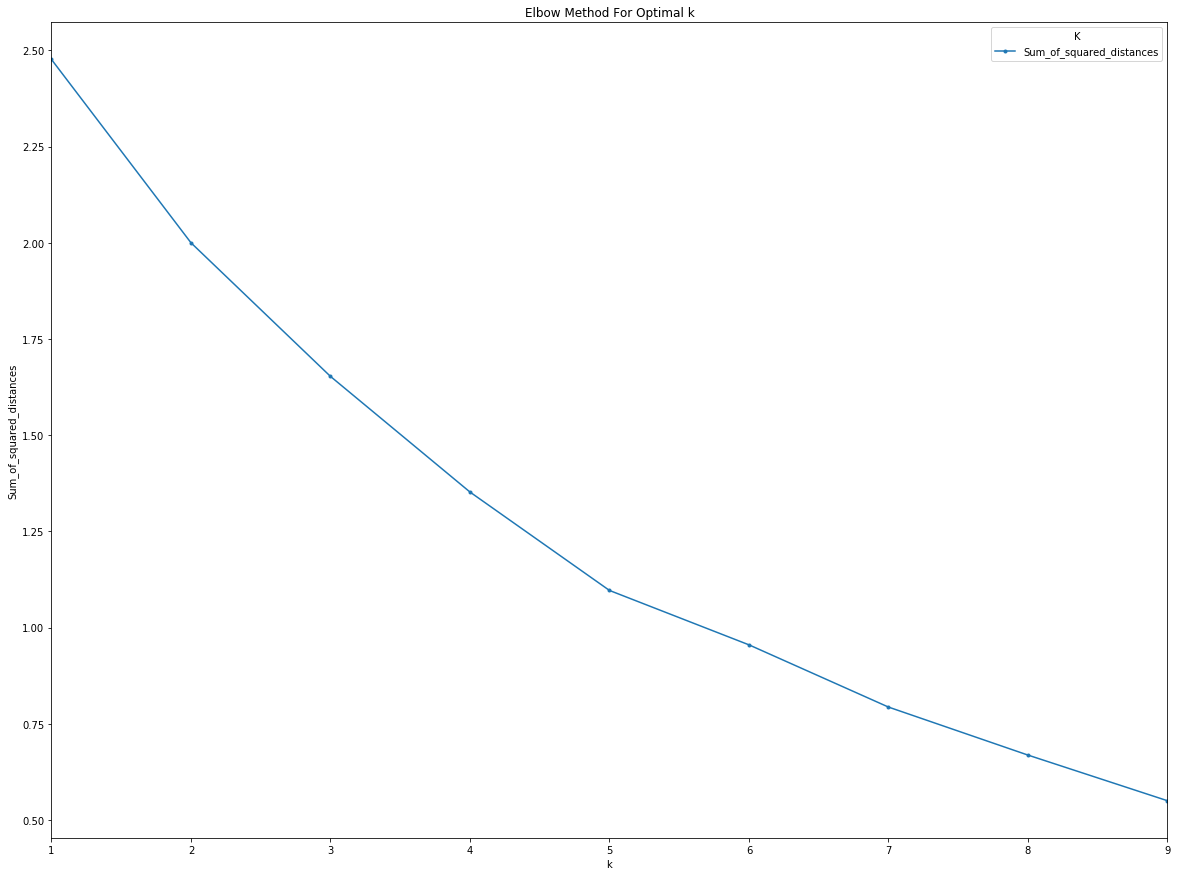

In [20]:
optimal_k= pd.DataFrame(data= Sum_of_squared_distances, columns = ['Sum_of_squared_distances'], index = K)
optimal_k.rename_axis('K', axis = 'columns', inplace = True)

optimal_k.plot(kind = 'line', figsize = (20, 15), marker = '.')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()


### Optimal K is 5.

In [21]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(london_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([4, 0, 1, 1, 1, 1, 1, 1, 1, 3], dtype=int32)

### Segment the neighborhoods by population's nationalities and most common venues.

In [22]:
london_merged = df.merge(neighborhoods_venues_sorted, how='inner', left_on='London Borough', right_on='Neighborhood')
london_merged['Cluster Labels'] = kmeans.labels_
london_merged

,London Borough,Indian Population,Pakistani Population,Bangladeshi Population,Chinese Population,Other Asian Population,Total Asian Population,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
0,Newham,42484,30307,37262,3930,19912,133895,Newham,Grocery Store,Café,Fish & Chips Shop,Convenience Store,Park,Electronics Store,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Women's Store,4
1,Redbridge,45660,31051,16011,3000,20781,116503,Redbridge,Supermarket,Indian Restaurant,Café,Coffee Shop,Greek Restaurant,Fast Food Restaurant,Middle Eastern Restaurant,Park,Pharmacy,Pizza Place,0
2,Brent,58017,14381,1749,3250,28589,105986,Brent,IT Services,Bus Station,Food Truck,Supermarket,Bus Stop,Café,Fast Food Restaurant,Middle Eastern Restaurant,Farmers Market,Falafel Restaurant,1
3,Tower Hamlets,6787,2442,81377,8109,5786,104501,Tower Hamlets,Coffee Shop,Persian Restaurant,Lebanese Restaurant,Museum,Canal Lock,Recreation Center,Fried Chicken Joint,Thrift / Vintage Store,Go Kart Track,Skate Park,1
4,Harrow,63051,7797,1378,2629,26953,101808,Harrow,Coffee Shop,Clothing Store,Pizza Place,Gym,Middle Eastern Restaurant,Movie Theater,Fast Food Restaurant,Rock Climbing Spot,Donut Shop,Bookstore,1
5,Ealing,48240,14711,1786,4132,31570,100439,Ealing,Fast Food Restaurant,Grocery Store,Hotel,Coffee Shop,Supermarket,Bakery,Doner Restaurant,Park,Diner,Furniture / Home Store,1
6,Hounslow,48161,13676,2189,2405,20826,87257,Hounslow,Hotel,Grocery Store,Middle Eastern Restaurant,Auto Garage,Pizza Place,Indian Restaurant,Department Store,Dessert Shop,Deli / Bodega,Diner,1
7,Hillingdon,36795,9200,2639,2889,17730,69253,Hillingdon,Construction & Landscaping,Chinese Restaurant,Breakfast Spot,Soccer Field,Department Store,Dessert Shop,Diner,Deli / Bodega,Fish & Chips Shop,Donut Shop,1
8,Barnet,27920,5344,2215,8259,22180,65918,Barnet,Café,Bus Stop,Women's Store,Fish & Chips Shop,Deli / Bodega,Department Store,Dessert Shop,Diner,Doner Restaurant,Donut Shop,1
9,Croydon,24660,10865,2570,3925,17607,59627,Croydon,Coffee Shop,Clothing Store,Bookstore,Platform,Pub,Portuguese Restaurant,Asian Restaurant,Hotel,Sushi Restaurant,Bus Stop,3


### Add the coordinates.

In [23]:
london_merged[['Latitude', 'Longitude']] = coordinates_df[['Latitude', 'Longitude']]
london_merged['Latitude'] = london_merged['Latitude'].astype(float)
london_merged['Longitude'] = london_merged['Longitude'].astype(float)
london_merged

,London Borough,Indian Population,Pakistani Population,Bangladeshi Population,Chinese Population,Other Asian Population,Total Asian Population,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels,Latitude,Longitude
0,Newham,42484,30307,37262,3930,19912,133895,Newham,Grocery Store,Café,Fish & Chips Shop,Convenience Store,Park,Electronics Store,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Women's Store,4,51.5255,0.0352
1,Redbridge,45660,31051,16011,3000,20781,116503,Redbridge,Supermarket,Indian Restaurant,Café,Coffee Shop,Greek Restaurant,Fast Food Restaurant,Middle Eastern Restaurant,Park,Pharmacy,Pizza Place,0,51.5901,0.0819
2,Brent,58017,14381,1749,3250,28589,105986,Brent,IT Services,Bus Station,Food Truck,Supermarket,Bus Stop,Café,Fast Food Restaurant,Middle Eastern Restaurant,Farmers Market,Falafel Restaurant,1,51.5673,-0.2711
3,Tower Hamlets,6787,2442,81377,8109,5786,104501,Tower Hamlets,Coffee Shop,Persian Restaurant,Lebanese Restaurant,Museum,Canal Lock,Recreation Center,Fried Chicken Joint,Thrift / Vintage Store,Go Kart Track,Skate Park,1,51.5203,-0.0293
4,Harrow,63051,7797,1378,2629,26953,101808,Harrow,Coffee Shop,Clothing Store,Pizza Place,Gym,Middle Eastern Restaurant,Movie Theater,Fast Food Restaurant,Rock Climbing Spot,Donut Shop,Bookstore,1,51.5806,-0.3420
5,Ealing,48240,14711,1786,4132,31570,100439,Ealing,Fast Food Restaurant,Grocery Store,Hotel,Coffee Shop,Supermarket,Bakery,Doner Restaurant,Park,Diner,Furniture / Home Store,1,51.5131,-0.3256
6,Hounslow,48161,13676,2189,2405,20826,87257,Hounslow,Hotel,Grocery Store,Middle Eastern Restaurant,Auto Garage,Pizza Place,Indian Restaurant,Department Store,Dessert Shop,Deli / Bodega,Diner,1,51.4609,-0.3731
7,Hillingdon,36795,9200,2639,2889,17730,69253,Hillingdon,Construction & Landscaping,Chinese Restaurant,Breakfast Spot,Soccer Field,Department Store,Dessert Shop,Diner,Deli / Bodega,Fish & Chips Shop,Donut Shop,1,51.5352,-0.4481
8,Barnet,27920,5344,2215,8259,22180,65918,Barnet,Café,Bus Stop,Women's Store,Fish & Chips Shop,Deli / Bodega,Department Store,Dessert Shop,Diner,Doner Restaurant,Donut Shop,1,51.6251,-0.1529
9,Croydon,24660,10865,2570,3925,17607,59627,Croydon,Coffee Shop,Clothing Store,Bookstore,Platform,Pub,Portuguese Restaurant,Asian Restaurant,Hotel,Sushi Restaurant,Bus Stop,3,51.3762,-0.0982


### Visualize our Clusters distribution on London's Map.

In [24]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(london_merged['Latitude'], london_merged['Longitude'], london_merged['Neighborhood'], london_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

##  Cluster

### Cluster 1

In [25]:
london_merged.loc[london_merged['Cluster Labels'] == 0, london_merged.columns[[0] + list(range(1, london_merged.shape[1]))]].sort_values(by = ['Chinese Population'], ascending = False)

,London Borough,Indian Population,Pakistani Population,Bangladeshi Population,Chinese Population,Other Asian Population,Total Asian Population,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels,Latitude,Longitude
1,Redbridge,45660,31051,16011,3000,20781,116503,Redbridge,Supermarket,Indian Restaurant,Café,Coffee Shop,Greek Restaurant,Fast Food Restaurant,Middle Eastern Restaurant,Park,Pharmacy,Pizza Place,0,51.5901,0.0819


### Cluster 2

In [26]:
london_merged.loc[london_merged['Cluster Labels'] == 1, london_merged.columns[[0] + list(range(1, london_merged.shape[1]))]].sort_values(by = ['Chinese Population'], ascending = False)

,London Borough,Indian Population,Pakistani Population,Bangladeshi Population,Chinese Population,Other Asian Population,Total Asian Population,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels,Latitude,Longitude
8,Barnet,27920,5344,2215,8259,22180,65918,Barnet,Café,Bus Stop,Women's Store,Fish & Chips Shop,Deli / Bodega,Department Store,Dessert Shop,Diner,Doner Restaurant,Donut Shop,1,51.6251,-0.1529
3,Tower Hamlets,6787,2442,81377,8109,5786,104501,Tower Hamlets,Coffee Shop,Persian Restaurant,Lebanese Restaurant,Museum,Canal Lock,Recreation Center,Fried Chicken Joint,Thrift / Vintage Store,Go Kart Track,Skate Park,1,51.5203,-0.0293
16,Greenwich,7836,2594,1645,5061,12758,29894,Greenwich,Park,Chinese Restaurant,Spa,Convenience Store,Pizza Place,Nightclub,Coffee Shop,Movie Theater,Portuguese Restaurant,Pub,1,51.4934,0.0098
5,Ealing,48240,14711,1786,4132,31570,100439,Ealing,Fast Food Restaurant,Grocery Store,Hotel,Coffee Shop,Supermarket,Bakery,Doner Restaurant,Park,Diner,Furniture / Home Store,1,51.5131,-0.3256
14,Wandsworth,8642,9718,1493,3715,9770,33338,Wandsworth,Pub,Café,Coffee Shop,Grocery Store,Park,Pizza Place,Indian Restaurant,Hotel,Deli / Bodega,Department Store,1,51.4571,-0.1818
2,Brent,58017,14381,1749,3250,28589,105986,Brent,IT Services,Bus Station,Food Truck,Supermarket,Bus Stop,Café,Fast Food Restaurant,Middle Eastern Restaurant,Farmers Market,Falafel Restaurant,1,51.5673,-0.2711
7,Hillingdon,36795,9200,2639,2889,17730,69253,Hillingdon,Construction & Landscaping,Chinese Restaurant,Breakfast Spot,Soccer Field,Department Store,Dessert Shop,Diner,Deli / Bodega,Fish & Chips Shop,Donut Shop,1,51.5352,-0.4481
19,Kingston Upon Thames,6325,3009,892,2883,13043,26152,Kingston Upon Thames,Coffee Shop,Café,Clothing Store,Bakery,Department Store,Stationery Store,Gym / Fitness Center,Sandwich Place,Japanese Restaurant,Supermarket,1,51.4123,-0.3007
4,Harrow,63051,7797,1378,2629,26953,101808,Harrow,Coffee Shop,Clothing Store,Pizza Place,Gym,Middle Eastern Restaurant,Movie Theater,Fast Food Restaurant,Rock Climbing Spot,Donut Shop,Bookstore,1,51.5806,-0.3420
11,Merton,8106,7337,2216,2618,15866,36143,Merton,Grocery Store,Locksmith,Pizza Place,Indian Restaurant,Train Station,Pub,Coffee Shop,Fast Food Restaurant,Bakery,Diner,1,51.4098,-0.2108


### Cluster 3

In [27]:
london_merged.loc[london_merged['Cluster Labels'] == 2, london_merged.columns[[0] + list(range(1, london_merged.shape[1]))]].sort_values(by = ['Chinese Population'], ascending = False)

,London Borough,Indian Population,Pakistani Population,Bangladeshi Population,Chinese Population,Other Asian Population,Total Asian Population,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels,Latitude,Longitude
18,Southwark,5819,1623,3912,8074,7764,27192,Southwark,Pub,Lake,Park,Café,Skate Park,Building,Gift Shop,Greek Restaurant,Cosmetics Shop,Deli / Bodega,2,51.4834,-0.0821
12,Camden,6083,1489,12503,6493,8878,35446,Camden,Gym / Fitness Center,Gastropub,Pharmacy,Pizza Place,Bakery,Coffee Shop,Café,Burger Joint,Hotel,Wine Shop,2,51.5517,-0.1588
15,Westminster,7213,2328,6299,5917,10105,31862,Westminster,Coffee Shop,Hotel,Sushi Restaurant,Sandwich Place,Theater,Pub,Restaurant,Indian Restaurant,Gym / Fitness Center,Juice Bar,2,51.4975,-0.1357
13,Enfield,11648,2594,5599,2588,12464,34893,Enfield,Pub,Auto Workshop,Restaurant,Tennis Court,Coffee Shop,Greek Restaurant,Go Kart Track,Convenience Store,Cosmetics Shop,Deli / Bodega,2,51.6636,-0.1043
10,Waltham Forest,9134,26347,4632,2579,11697,54389,Waltham Forest,Grocery Store,Coffee Shop,Pub,Concert Hall,Pizza Place,Deli / Bodega,Field,Pool,Vegetarian / Vegan Restaurant,Gym,2,51.5886,-0.0118
17,Barking and Dagenham,7436,8007,7701,1315,5135,29594,Barking and Dagenham,Construction & Landscaping,Park,Fish & Chips Shop,Cosmetics Shop,Deli / Bodega,Department Store,Dessert Shop,Diner,Doner Restaurant,Donut Shop,2,51.5465,0.1293


### Cluster 4

In [28]:
london_merged.loc[london_merged['Cluster Labels'] == 3, london_merged.columns[[0] + list(range(1, london_merged.shape[1]))]].sort_values(by = ['Chinese Population'], ascending = False)

,London Borough,Indian Population,Pakistani Population,Bangladeshi Population,Chinese Population,Other Asian Population,Total Asian Population,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels,Latitude,Longitude
9,Croydon,24660,10865,2570,3925,17607,59627,Croydon,Coffee Shop,Clothing Store,Bookstore,Platform,Pub,Portuguese Restaurant,Asian Restaurant,Hotel,Sushi Restaurant,Bus Stop,3,51.3762,-0.0982


### Cluster 5

In [29]:
london_merged.loc[london_merged['Cluster Labels'] == 4, london_merged.columns[[0] + list(range(1, london_merged.shape[1]))]].sort_values(by = ['Chinese Population'], ascending = False)

,London Borough,Indian Population,Pakistani Population,Bangladeshi Population,Chinese Population,Other Asian Population,Total Asian Population,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels,Latitude,Longitude
0,Newham,42484,30307,37262,3930,19912,133895,Newham,Grocery Store,Café,Fish & Chips Shop,Convenience Store,Park,Electronics Store,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Women's Store,4,51.5255,0.0352


## Conclusion

As we can see, analyzing this dataset, the highest amount of Chinese population is located at Barnet and Tower Hamlets represented in cluster 2. Interestingly, we don't see any Chinese restaurants in the top ten most common venues. Therefore, we have a great business opportunity, in view of the large number of Chinese population living in this region.